In [3]:
import re
import pandas as pd

# File paths
log_file_path = '14putty172623.log'
output_csv_path = 'sensor_data.csv'

# Reading the log file
with open(log_file_path, 'r') as file:
    log_data = file.readlines()

# Initialize lists to store data
acc_data = []
gyro_data = []
states = []
current_state = None  # To keep track of the current state

# Regular expressions to extract Acc and Gyro data
acc_pattern = re.compile(r"Acc\. X = ([\d.-]+), Y = ([\d.-]+), Z = ([\d.-]+)")
gyro_pattern = re.compile(r"Gyro\. X = ([\d.-]+), Y = ([\d.-]+), Z = ([\d.-]+)")
state_pattern = re.compile(r"State: (\d+)")  # Pattern to extract state

# Loop through each line in the log data
for line in log_data:
    acc_match = acc_pattern.search(line)
    gyro_match = gyro_pattern.search(line)
    state_match = state_pattern.search(line)

    if acc_match:
        # Extract accelerometer data
        acc_x, acc_y, acc_z = float(acc_match.group(1)), float(acc_match.group(2)), float(acc_match.group(3))

    if gyro_match:
        # Extract gyroscope data
        gyro_x, gyro_y, gyro_z = float(gyro_match.group(1)), float(gyro_match.group(2)), float(gyro_match.group(3))

        # After extracting gyro data, append the state if it exists
        if current_state is not None:
            acc_data.append([acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z, current_state])

    if state_match:
        # Update the current state when a new state is found
        current_state = int(state_match.group(1))

# Create DataFrame
sensor_df = pd.DataFrame(acc_data, columns=['Acc_X', 'Acc_Y', 'Acc_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'State'])

# Write the dataframe to a CSV file
sensor_df.to_csv(output_csv_path, index=False)

print(f"Data has been successfully converted to CSV format and saved as '{output_csv_path}'")


Data has been successfully converted to CSV format and saved as 'sensor_data.csv'


In [4]:
import pandas as pd

# Function to convert state to power
def label_power_state(state):
    if state == 1:
        return 0  # 0% power
    elif state == 2:
        return 0.2 * 620  # 20% of 620kV
    elif state == 3:
        return 0.3 * 620  # 30% of 620kV
    elif state == 4:
        return 0.4 * 620  # 40% of 620kV
    elif state == 5:
        return 0.5 * 620  # 50% of 620kV
    else:
        return 0  # Invalid state

# File paths
input_csv_path = 'sensor_data.csv'  # Input CSV
output_csv_path = 'sensor_data_with_power.csv'  # Output CSV

# Load the CSV file
sensor_df = pd.read_csv(input_csv_path)

# Check if 'State' column exists
if 'State' in sensor_df.columns:
    # Apply the function to replace state with power values
    sensor_df['Power_State_Label'] = sensor_df['State'].apply(label_power_state)

    # Drop the 'State' column as requested
    sensor_df = sensor_df.drop(columns=['State'])

    # Save the updated DataFrame to a new CSV file
    sensor_df.to_csv(output_csv_path, index=False)

    print(f"CSV file updated with Power_State_Label and saved as '{output_csv_path}'")
else:
    print("Error: 'State' column not found in the input CSV.")


CSV file updated with Power_State_Label and saved as 'sensor_data_with_power.csv'


In [5]:
# Print the first few rows of the DataFrame to check
print(sensor_df.head())


      Acc_X     Acc_Y      Acc_Z  Gyro_X  Gyro_Y  Gyro_Z  Power_State_Label
0 -0.535626 -0.073575 -14.334372     0.0     0.0  -171.0                0.0
1 -0.535626 -0.073575  12.335967     0.0     0.0   168.0                0.0
2 -0.535626 -0.073575 -14.334372     0.0     0.0  -171.0                0.0
3 -0.535626 -0.073575  12.335967     0.0     0.0   168.0                0.0
4 -0.535626 -0.073575 -14.334372     0.0     0.0  -171.0                0.0


In [6]:
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import warnings
warnings.filterwarnings("ignore")
# Normalizing the data using MinMaxScaler
scaler = MinMaxScaler()
sensor_df_scaled = scaler.fit_transform(sensor_df)

# Defining a function to create sequences for LSTM input
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)

# Defining sequence length (e.g., 10 time steps)
sequence_length = 100


In [7]:
# Example of different sequence lengths
for sequence_length in [5, 10, 15, 20,50,100]:
    sequences = create_sequences(sensor_df_scaled, sequence_length)
    print(f"Number of sequences for length {sequence_length}: {len(sequences)}")


Number of sequences for length 5: 166720
Number of sequences for length 10: 166715
Number of sequences for length 15: 166710
Number of sequences for length 20: 166705
Number of sequences for length 50: 166675
Number of sequences for length 100: 166625


In [8]:
print(sensor_df.isna().sum())

Acc_X                0
Acc_Y                0
Acc_Z                0
Gyro_X               0
Gyro_Y               0
Gyro_Z               0
Power_State_Label    0
dtype: int64


In [9]:
# Creating sequences from the scaled data
sensor_sequences = create_sequences(sensor_df_scaled, sequence_length)

# Debugging: Check the shape of the created sequences
print(f"Shape of sensor_sequences: {sensor_sequences.shape}")

# Splitting the data into features (X) and labels (y)
X = sensor_sequences[:, :-1]  # All but the last timestep as input

# Assuming Power_State_Label is at index 6
y_class = sensor_sequences[:, -1, 6].astype(int)  # Using the last sequence for Power_State_Label

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_class[:len(X)], test_size=0.2, random_state=42)



Shape of sensor_sequences: (166625, 100, 7)


In [10]:
import pandas as pd

# Read the CSV file
file_path = 'sensor_data_with_power.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
print("Data Preview:")
print(data.head())

# Count unique values in the 'Power_State_Label' column
unique_counts = data['Power_State_Label'].value_counts()

# Display the unique counts
print("\nUnique Counts of Power State Labels:")
print(unique_counts)


Data Preview:
      Acc_X     Acc_Y      Acc_Z  Gyro_X  Gyro_Y  Gyro_Z  Power_State_Label
0 -0.535626 -0.073575 -14.334372     0.0     0.0  -171.0                0.0
1 -0.535626 -0.073575  12.335967     0.0     0.0   168.0                0.0
2 -0.535626 -0.073575 -14.334372     0.0     0.0  -171.0                0.0
3 -0.535626 -0.073575  12.335967     0.0     0.0   168.0                0.0
4 -0.535626 -0.073575 -14.334372     0.0     0.0  -171.0                0.0

Unique Counts of Power State Labels:
Power_State_Label
0.0      39427
186.0    37754
124.0    31850
248.0    30144
310.0    27550
Name: count, dtype: int64


In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping

# Assuming X_train, y_train, X_test, y_test are already defined

# Building the LSTM model for classification
model = Sequential()
model.add(LSTM(10, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(BatchNormalization())
model.add(LSTM(10, activation='relu'))  # Second LSTM layer
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(6, activation='softmax'))  # For multi-class classification (0-5 for power states)

# Compiling the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Print the test accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Saving the model
model.save("lstm_sensor_model_classification.h5")


Epoch 1/10
2083/2083 ━━━━━━━━━━━━━━━━━━━━ 171s 80ms/step - accuracy: 0.8408 - loss: 0.5572 - val_accuracy: 0.9994 - val_loss: 0.0037
Epoch 2/10
2083/2083 ━━━━━━━━━━━━━━━━━━━━ 204s 81ms/step - accuracy: 0.9988 - loss: 0.0069 - val_accuracy: 0.9998 - val_loss: 0.0019
Epoch 3/10
2083/2083 ━━━━━━━━━━━━━━━━━━━━ 197s 79ms/step - accuracy: 0.9988 - loss: 0.0051 - val_accuracy: 0.9998 - val_loss: 0.0012
Epoch 4/10
2083/2083 ━━━━━━━━━━━━━━━━━━━━ 201s 79ms/step - accuracy: 0.9993 - loss: 0.0034 - val_accuracy: 0.9998 - val_loss: 0.0012
Epoch 5/10
2083/2083 ━━━━━━━━━━━━━━━━━━━━ 163s 78ms/step - accuracy: 0.9993 - loss: 0.0033 - val_accuracy: 0.9999 - val_loss: 7.4195e-04
Epoch 6/10
2083/2083 ━━━━━━━━━━━━━━━━━━━━ 166s 80ms/step - accuracy: 0.9994 - loss: 0.0021 - val_accuracy: 0.9998 - val_loss: 7.9282e-04
Epoch 7/10
2083/2083 ━━━━━━━━━━━━━━━━━━━━ 158s 76ms/step - accuracy: 0.9995 - loss: 0.0022 - val_accuracy: 0.9998 - val_loss: 7.0007e-04
Epoch 8/10
2083/2083 ━━━━━━━━━━━━━━━━━━━━ 199s 74ms/step 

Test Accuracy: 99.99%


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Print the test accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

1042/1042 [==============================] - 17s 16ms/step - loss: 6.0486e-04 - accuracy: 0.9999
Test Accuracy: 99.99%


1042/1042 [==============================] - 17s 16ms/step
Confusion Matrix:
 [[27714     0]
 [    2  5609]]


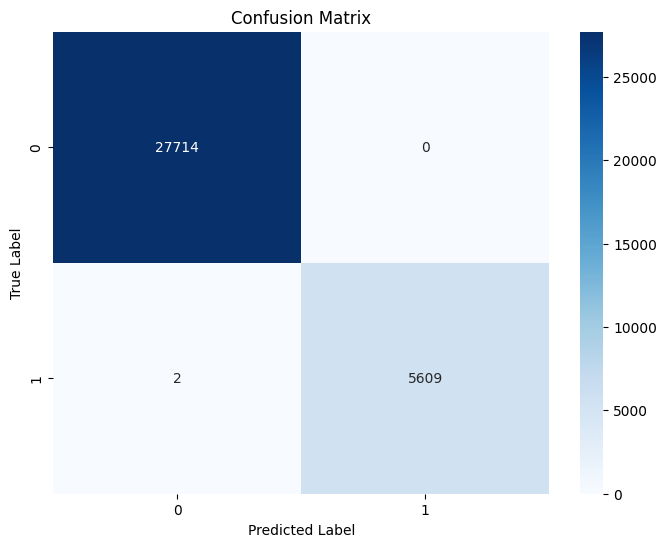

RMSE: 0.0077


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, mean_squared_error
# Getting predictions on the test data
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)  # Get predicted class labels

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_labels)
print("Confusion Matrix:\n", cm)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 2. RMSE for classification
rmse = np.sqrt(mean_squared_error(y_test, y_pred_labels))
print(f"RMSE: {rmse:.4f}")


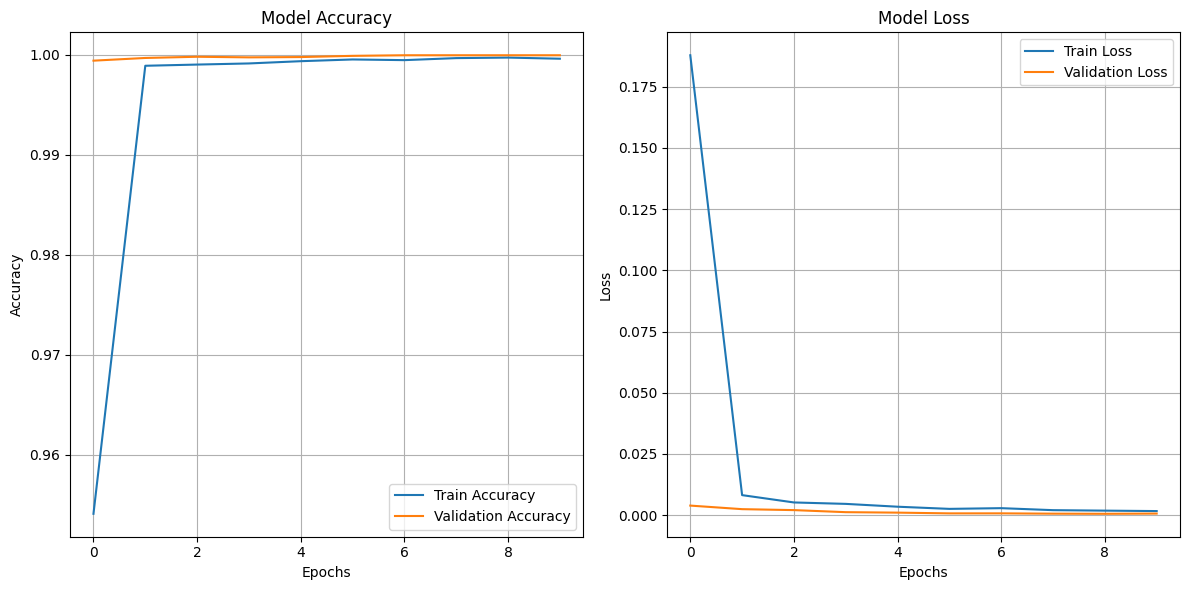

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Show the plots
plt.tight_layout()
plt.show()


Training Progress:   0%|                                                                       | 0/5 [00:00<?, ?fold/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Training fold 1...
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
buildi

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.3s


building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100building tree 74 of 100

building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
Training Progress:  20%|████████████▌                                                  | 1/5 [00:01<00:04,  1.20s/fold]

building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
Confusion Matrix for fold 1:
 [[13  6 10  1  3  4]
 [ 5 12  7  4  0  3]
 [ 4  1 12  1  4  4]
 [ 4  7  8 10  1  5]
 [ 6  8  9  4  5  5]
 [ 4  5 11  4  5  5]]
Accuracy for fold 1: 28.50%
RMSE for fold 1: 2.19
Training fold 2...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100building tree 26 of 100

building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.2s


building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
Training Progress:  40%|█████████████████████████▏                                     | 2/5 [00:02<00:03,  1.12s/fold]

building tree 94 of 100building tree 95 of 100

building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
Confusion Matrix for fold 2:
 [[18  3  6  3  2  1]
 [10 11  3  5  6  6]
 [ 6  0  9  3  4 13]
 [ 5  3  5 11  8  6]
 [ 6  3 10  4  2  6]
 [ 3  2  5  3  4  5]]
Accuracy for fold 2: 28.00%
RMSE for fold 2: 2.11
Training fold 3...
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 1

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.2s


building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
Training Progress:  60%|█████████████████████████████████████▊                         | 3/5 [00:03<00:02,  1.05s/fold][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Confusion Matrix for fold 3:
 [[15  7  1  1  0  1]
 [ 7 11  1  5  3  2]
 [ 7 12  7  8  3  6]
 [ 0  6  1 13  4  2]
 [ 7  6  4  4  8  6]
 [ 5  9  6  8  6  8]]
Accuracy for fold 3: 31.00%
RMSE for fold 3: 2.04
Training fold 4...
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 3

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.2s


building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100building tree 70 of 100

building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
Training Progress:  80%|██████████████████████████████████████████████████▍            | 4/5 [00:04<00:01,  1.03s/fold]

building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
Confusion Matrix for fold 4:
 [[12  5  4  3  0  4]
 [11  7  7  5  2  4]
 [ 6  2 12  2  6  6]
 [ 6  2  5 12  5  7]
 [ 6  4  4  3  7  7]
 [ 6  5  4  4  4 11]]
Accuracy for fold 4: 30.50%
RMSE for fold 4: 2.14
Training fold 5...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.2s


building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
Training Progress: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.09s/fold]

Confusion Matrix for fold 5:
 [[14 12  6  5  4  2]
 [ 5  8  1  9  6  3]
 [ 2  7  7  5  4  4]
 [ 1  4  7 11  4  3]
 [ 3  9  4  2  8  5]
 [ 2  6  7 10  6  4]]
Accuracy for fold 5: 26.00%
RMSE for fold 5: 2.08
Average Accuracy: 28.80%
Average RMSE: 2.11



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.5s


building tree 39 of 100building tree 40 of 100
building tree 41 of 100

building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished


Final Test Accuracy: 71.94%
Final Test RMSE: 1.54
Final Test Confusion Matrix:
 [[23367   661     3  1206  2477]
 [ 4991   608     0     1    11]
 [    0     0     0     0     0]
 [    0     0     0     0     0]
 [    0     0     0     0     0]]


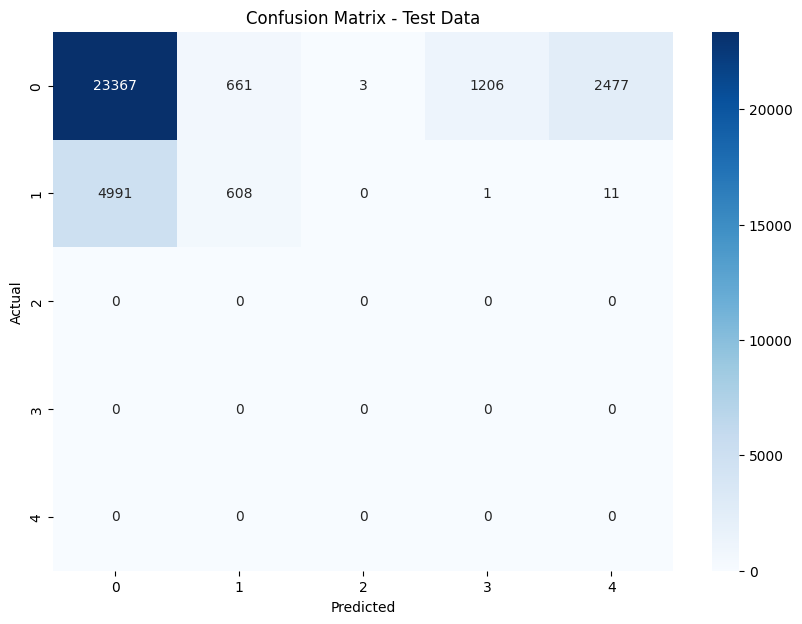

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from tqdm import tqdm  # For the progress bar
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X_train, y_train, X_test, y_test are already defined
# Here we use a sample dataset for illustration
from sklearn.datasets import make_classification

# Generating a sample dataset with 6 classes and enough informative features
X, y = make_classification(n_samples=1000, n_features=693, n_informative=6, n_classes=6, random_state=42)

# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize progress bar
progress_bar = tqdm(total=kf.get_n_splits(), desc="Training Progress", unit="fold")

# Initialize lists to store scores
accuracy_scores = []
rmse_scores = []

# Loop through the KFold splits
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Training fold {fold + 1}...")

    # Split the data
    X_fold_train, X_fold_test = X[train_index], X[test_index]
    y_fold_train, y_fold_test = y[train_index], y[test_index]

    # Initialize Random Forest model
    random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbose=2)

    # Train the model
    random_forest_model.fit(X_fold_train, y_fold_train)

    # Make predictions
    y_pred = random_forest_model.predict(X_fold_test)

    # Calculate accuracy for the current fold
    accuracy = accuracy_score(y_fold_test, y_pred)
    accuracy_scores.append(accuracy)

    # Calculate RMSE for the current fold
    rmse = np.sqrt(mean_squared_error(y_fold_test, y_pred))
    rmse_scores.append(rmse)

    # Display the confusion matrix for this fold
    conf_matrix = confusion_matrix(y_fold_test, y_pred)
    print(f"Confusion Matrix for fold {fold + 1}:\n", conf_matrix)

    # Update the progress bar
    progress_bar.update(1)

    print(f"Accuracy for fold {fold + 1}: {accuracy * 100:.2f}%")
    print(f"RMSE for fold {fold + 1}: {rmse:.2f}")

# Close the progress bar
progress_bar.close()

# Calculate and print the average accuracy and RMSE across all folds
average_accuracy = np.mean(accuracy_scores)
average_rmse = np.mean(rmse_scores)
print(f"Average Accuracy: {average_accuracy * 100:.2f}%")
print(f"Average RMSE: {average_rmse:.2f}")

# Final evaluation on test data
final_rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbose=2)
final_rf_model.fit(X, y)  # Train on entire data

print(f"X_test shape: {X_test.shape}")

# If X_test has more than 2 dimensions, reshape it
if len(X_test.shape) > 2:
    # Reshape to remove extra dimensions
    X_test = X_test.reshape(X_test.shape[0], -1)

# Now make predictions on the test data
y_test_pred = final_rf_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_test_pred)
final_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
final_conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print final test accuracy, RMSE and confusion matrix
print(f"Final Test Accuracy: {final_accuracy * 100:.2f}%")
print(f"Final Test RMSE: {final_rmse:.2f}")
print(f"Final Test Confusion Matrix:\n", final_conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(final_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test Data")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


In [ ]:
print(f"X_test shape: {X_test.shape}")

# If X_test has more than 2 dimensions, reshape it
if len(X_test.shape) > 2:
    # Reshape to remove extra dimensions
    X_test = X_test.reshape(X_test.shape[0], -1)

# Now make predictions
y_test_pred = final_rf_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Final Test Accuracy: {final_accuracy * 100:.2f}%")


X_test shape: (33325, 693)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.2s


Final Test Accuracy: 71.94%


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished
